In [0]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [7]:
DIRECTORY = "/content/drive/My Drive/Colab Notebooks/lsda/HW1/" #Mahdi

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [0]:
pd.options.display.max_columns = 50

In [0]:
h = 28 
max_lags = 364 + 364 + 1 # max_lag + max_window + 1
tr_last = 1913 - 28 #CHANGE
fday = datetime(2016,4, 25) -timedelta(days=28) #CHANGE
FIRST_DAY = 1
VERSION = "base_model_magic_rmse" # remove last 28 days
LAG = [7, 28, 364]
WINDOW = LAG

params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        "metric": ["rmse"],
    'verbosity': 1,
    'num_iterations' : 1200,
    'num_leaves': 128,
    "min_data_in_leaf": 100,
}

In [0]:
def create_dt(is_train = True, nrows = None, first_day = 1200, tr_last=tr_last):
    prices = pd.read_csv(DIRECTORY + "data/sell_prices.csv", dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv(DIRECTORY + "data/calendar.csv", dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv(DIRECTORY + "data/sales_train_validation.csv", #CHANGE
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return dt

In [0]:
def create_fea(dt):
    lags = LAG
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = WINDOW
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            #dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby('id')[lag_col].shift(1).rolling(win, min_periods=1).mean() #optimized
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

In [0]:
# def create_lag_features_for_test(dt, day):
#     # create lag feaures just for single day (faster)
#     print(dt)
#     lags = [7, 28, 364]
#     lag_cols = [f"lag_{lag}" for lag in lags]
#     for lag, lag_col in zip(lags, lag_cols):
#         print(dt.loc[dt.date == day, lag_col])
#         dt.loc[dt.date == day, lag_col] = dt.loc[dt.date ==day-timedelta(days=lag), 'sales'].values  # !!! main
#         print(dt.loc[dt.date ==day-timedelta(days=lag), 'sales'])

#     windows = [7, 28, 364]
#     for window in windows:
#         for lag in lags:
#             df_window = dt[(dt.date <= day-timedelta(days=lag)) & (dt.date > day-timedelta(days=lag+window))]
#             df_window_grouped = df_window.groupby("id").agg({'sales':'mean'}).reindex(dt.loc[dt.date==day,'id'])
#             dt.loc[dt.date == day,f"rmean_{lag}_{window}"] = df_window_grouped.sales.values  

# def create_date_features_for_test(dt):
#     # copy of the code from `create_dt()` above
#     date_features = {
#         "wday": "weekday",
#         "week": "weekofyear",
#         "month": "month",
#         "quarter": "quarter",
#         "year": "year",
#         "mday": "day",
#     }

#     for date_feat_name, date_feat_func in date_features.items():
#         if date_feat_name in dt.columns:
#             dt[date_feat_name] = dt[date_feat_name].astype("int16")
#         else:
#             dt[date_feat_name] = getattr(
#                 dt["date"].dt, date_feat_func).astype("int16")

In [0]:
df = create_dt(is_train=True, first_day= FIRST_DAY)

In [15]:
create_fea(df)
df

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,lag_364,rmean_7_7,rmean_28_7,rmean_364_7,rmean_7_28,rmean_28_28,rmean_364_28,rmean_7_364,rmean_28_364,rmean_364_364,week,quarter,mday
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,29
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,30
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,31
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45174232,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1885,1.0,2016-03-27,11609,3,2,3,2016,5,1,0,0,0.0,0.0,0.0,3.98,0.0,0.0,0.0,1.000000,0.428571,0.857143,1.178571,0.642857,0.892857,0.662088,0.631868,0.958791,12,1,27
45174233,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1884,2.0,2016-03-26,11609,2,1,3,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,0.0,0.0,1.428571,0.000000,0.000000,0.821429,1.000000,0.142857,0.980769,0.928571,0.423077,12,1,26
45174234,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1885,4.0,2016-03-27,11609,3,2,3,2016,5,1,0,0,0.0,0.0,0.0,1.28,1.0,0.0,0.0,1.142857,0.000000,0.000000,0.857143,0.892857,0.142857,0.983516,0.928571,0.423077,12,1,27
45174235,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1884,0.0,2016-03-26,11609,2,1,3,2016,0,0,0,0,0.0,0.0,0.0,1.00,1.0,4.0,1.0,2.142857,1.571429,1.571429,1.607143,1.607143,0.821429,1.760989,1.700549,1.640110,12,1,26


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45174237 entries, 0 to 45174236
Data columns (total 37 columns):
 #   Column         Dtype         
---  ------         -----         
 0   id             object        
 1   item_id        int16         
 2   dept_id        int16         
 3   store_id       int16         
 4   cat_id         int16         
 5   state_id       int16         
 6   d              object        
 7   sales          float32       
 8   date           datetime64[ns]
 9   wm_yr_wk       int16         
 10  weekday        int16         
 11  wday           int16         
 12  month          int16         
 13  year           int16         
 14  event_name_1   int16         
 15  event_type_1   int16         
 16  event_name_2   int16         
 17  event_type_2   int16         
 18  snap_CA        float32       
 19  snap_TX        float32       
 20  snap_WI        float32       
 21  sell_price     float32       
 22  lag_7          float32       
 23  lag_2

In [17]:
df.dropna(inplace = True)
df.shape

(23602466, 37)

In [18]:
df

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,lag_364,rmean_7_7,rmean_28_7,rmean_364_7,rmean_7_28,rmean_28_28,rmean_364_28,rmean_7_364,rmean_28_364,rmean_364_364,week,quarter,mday
12729751,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_728,0.0,2013-01-25,11252,0,7,1,2013,0,0,0,0,0.0,0.0,0.0,0.46,0.0,0.0,8.0,0.000000,0.000000,11.000000,0.000000,0.000000,9.607142,3.236264,3.763736,6.824176,4,1,25
12729758,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_728,0.0,2013-01-25,11252,0,7,1,2013,0,0,0,0,0.0,0.0,0.0,1.77,1.0,1.0,3.0,1.857143,1.285714,0.714286,1.571429,1.750000,1.821429,1.667582,1.697802,1.821429,4,1,25
12729765,HOBBIES_1_010_CA_1_validation,9,0,0,0,0,d_728,1.0,2013-01-25,11252,0,7,1,2013,0,0,0,0,0.0,0.0,0.0,2.97,0.0,0.0,1.0,0.714286,0.428571,1.000000,0.678571,0.750000,0.714286,0.895604,0.887363,0.543956,4,1,25
12729779,HOBBIES_1_012_CA_1_validation,11,0,0,0,0,d_728,0.0,2013-01-25,11252,0,7,1,2013,0,0,0,0,0.0,0.0,0.0,6.52,0.0,2.0,0.0,0.714286,0.857143,0.285714,0.607143,0.535714,0.464286,0.420330,0.420330,0.552198,4,1,25
12729800,HOBBIES_1_015_CA_1_validation,14,0,0,0,0,d_728,0.0,2013-01-25,11252,0,7,1,2013,0,0,0,0,0.0,0.0,0.0,0.72,1.0,1.0,0.0,3.000000,2.285714,7.714286,3.071429,3.928571,5.821429,5.203297,5.310440,6.722528,4,1,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45174232,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1885,1.0,2016-03-27,11609,3,2,3,2016,5,1,0,0,0.0,0.0,0.0,3.98,0.0,0.0,0.0,1.000000,0.428571,0.857143,1.178571,0.642857,0.892857,0.662088,0.631868,0.958791,12,1,27
45174233,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1884,2.0,2016-03-26,11609,2,1,3,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,0.0,0.0,1.428571,0.000000,0.000000,0.821429,1.000000,0.142857,0.980769,0.928571,0.423077,12,1,26
45174234,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1885,4.0,2016-03-27,11609,3,2,3,2016,5,1,0,0,0.0,0.0,0.0,1.28,1.0,0.0,0.0,1.142857,0.000000,0.000000,0.857143,0.892857,0.142857,0.983516,0.928571,0.423077,12,1,27
45174235,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1884,0.0,2016-03-26,11609,2,1,3,2016,0,0,0,0,0.0,0.0,0.0,1.00,1.0,4.0,1.0,2.142857,1.571429,1.571429,1.607143,1.607143,0.821429,1.760989,1.700549,1.640110,12,1,26


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23602466 entries, 12729751 to 45174236
Data columns (total 37 columns):
 #   Column         Dtype         
---  ------         -----         
 0   id             object        
 1   item_id        int16         
 2   dept_id        int16         
 3   store_id       int16         
 4   cat_id         int16         
 5   state_id       int16         
 6   d              object        
 7   sales          float32       
 8   date           datetime64[ns]
 9   wm_yr_wk       int16         
 10  weekday        int16         
 11  wday           int16         
 12  month          int16         
 13  year           int16         
 14  event_name_1   int16         
 15  event_type_1   int16         
 16  event_name_2   int16         
 17  event_type_2   int16         
 18  snap_CA        float32       
 19  snap_TX        float32       
 20  snap_WI        float32       
 21  sell_price     float32       
 22  lag_7          float32       
 23

In [0]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]

In [0]:
np.random.seed(42)

fake_valid_inds = np.random.choice(X_train.index.values, 2_000_000, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)
train_data = lgb.Dataset(X_train.loc[train_inds] , label = y_train.loc[train_inds], categorical_feature=cat_feats, free_raw_data=False)
fake_valid_data = lgb.Dataset(X_train.loc[fake_valid_inds], label = y_train.loc[fake_valid_inds],
                              categorical_feature=cat_feats,
                 free_raw_data=False)# This is a random sample, we're not gonna apply any time series train-test-split tricks here!

In [22]:
del df, X_train, y_train, fake_valid_inds, train_inds ; gc.collect()

0

In [23]:
%%time
m_lgb = lgb.train(params, train_data, valid_sets=[fake_valid_data], verbose_eval=20) 

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[20]	valid_0's rmse: 2.94863
[40]	valid_0's rmse: 2.63366
[60]	valid_0's rmse: 2.55609
[80]	valid_0's rmse: 2.53492
[100]	valid_0's rmse: 2.52426
[120]	valid_0's rmse: 2.51577
[140]	valid_0's rmse: 2.50737
[160]	valid_0's rmse: 2.4966
[180]	valid_0's rmse: 2.48601
[200]	valid_0's rmse: 2.47854
[220]	valid_0's rmse: 2.47016
[240]	valid_0's rmse: 2.46145
[260]	valid_0's rmse: 2.45489
[280]	valid_0's rmse: 2.44849
[300]	valid_0's rmse: 2.44424
[320]	valid_0's rmse: 2.4397
[340]	valid_0's rmse: 2.4338
[360]	valid_0's rmse: 2.42865
[380]	valid_0's rmse: 2.42615
[400]	valid_0's rmse: 2.42206
[420]	valid_0's rmse: 2.41881
[440]	valid_0's rmse: 2.41519
[460]	valid_0's rmse: 2.41237
[480]	valid_0's rmse: 2.40921
[500]	valid_0's rmse: 2.40696
[520]	valid_0's rmse: 2.40372
[540]	valid_0's rmse: 2.40103
[560]	valid_0's rmse: 2.39893
[580]	valid_0's rmse: 2.3954
[600]	valid_0's rmse: 2.39337
[620]	valid_0's rmse: 2.3912
[640]	valid_0's rmse: 2.38866
[660]	valid_0's rmse: 2.38595
[680]	valid_0's rms

In [0]:
#2.30653 DEFAULT NO MAGIC NUMBER

In [25]:
m_lgb.save_model(DIRECTORY + "models/model_v" + str(VERSION) + ".lgb")

In [0]:
# # # #load model
# m_lgb = lgb.Booster(model_file=DIRECTORY + "models/model_v" + str(VERSION) + ".lgb")

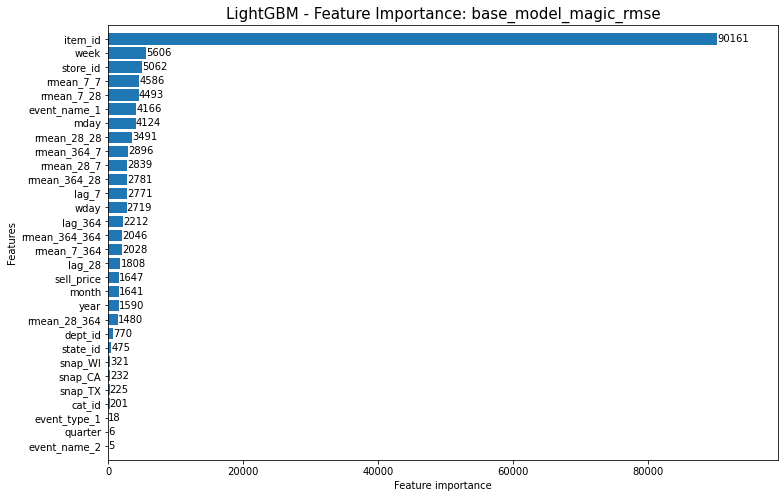

In [27]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18.0, 4)
%matplotlib inline 

fig, ax = plt.subplots(figsize=(12,8))
lgb.plot_importance(m_lgb, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance: " + str(VERSION), fontsize=15)
plt.savefig(DIRECTORY + "models/model_v" + str(VERSION) + ".png")
#plt.show()

In [0]:
# %%time
# te = create_dt(False)
# #create_date_features_for_test(te)
# cols = [f"F{i}" for i in range(1,29)]


# for tdelta in range(0, 28):
#     day = fday + timedelta(days=tdelta)
#     print(tdelta, day)
#     tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
#     create_fea(tst) #old, slow
#     #create_lag_features_for_test(tst, day)  # faster  optimized
#     tst = tst.loc[tst.date == day , train_cols]
#     te.loc[te.date == day, "sales"] = m_lgb.predict(tst)



# te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
# te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
# te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
# te_sub.fillna(0., inplace = True)
# te_sub.sort_values("id", inplace = True)
# te_sub.reset_index(drop=True, inplace = True)

In [29]:
%%time

alphas = [1.028, 1.023, 1.018]
weights = [1/len(alphas)]*len(alphas)
sub = 0.

for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

    te = create_dt(False)
    cols = [f"F{i}" for i in range(1,29)]

    for tdelta in range(0, 28):
        day = fday + timedelta(days=tdelta)
        print(tdelta, day)
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        create_fea(tst)
        tst = tst.loc[tst.date == day , train_cols]
        te.loc[te.date == day, "sales"] = alpha*m_lgb.predict(tst) # magic multiplier by kyakovlev



    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
#     te_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = te_sub.loc[te.date >= fday+timedelta(days=h), 
#                                                                           "id"].str.replace("validation$", "evaluation")
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    te_sub.fillna(0., inplace = True)
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
    te_sub.to_csv(f"submission_{icount}.csv",index=False)
    if icount == 0 :
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight
    print(icount, alpha, weight)


sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv(DIRECTORY + "submissions/submission_v" + str(VERSION) + ".csv",index=False)

0 2016-03-28 00:00:00
1 2016-03-29 00:00:00
2 2016-03-30 00:00:00
3 2016-03-31 00:00:00
4 2016-04-01 00:00:00
5 2016-04-02 00:00:00
6 2016-04-03 00:00:00
7 2016-04-04 00:00:00
8 2016-04-05 00:00:00
9 2016-04-06 00:00:00
10 2016-04-07 00:00:00
11 2016-04-08 00:00:00
12 2016-04-09 00:00:00
13 2016-04-10 00:00:00
14 2016-04-11 00:00:00
15 2016-04-12 00:00:00
16 2016-04-13 00:00:00
17 2016-04-14 00:00:00
18 2016-04-15 00:00:00
19 2016-04-16 00:00:00
20 2016-04-17 00:00:00
21 2016-04-18 00:00:00
22 2016-04-19 00:00:00
23 2016-04-20 00:00:00
24 2016-04-21 00:00:00
25 2016-04-22 00:00:00
26 2016-04-23 00:00:00
27 2016-04-24 00:00:00
0 1.028 0.3333333333333333
0 2016-03-28 00:00:00
1 2016-03-29 00:00:00
2 2016-03-30 00:00:00
3 2016-03-31 00:00:00
4 2016-04-01 00:00:00
5 2016-04-02 00:00:00
6 2016-04-03 00:00:00
7 2016-04-04 00:00:00
8 2016-04-05 00:00:00
9 2016-04-06 00:00:00
10 2016-04-07 00:00:00
11 2016-04-08 00:00:00
12 2016-04-09 00:00:00
13 2016-04-10 00:00:00
14 2016-04-11 00:00:00
15 2

In [0]:
#te_sub.to_csv(DIRECTORY + "submissions/submission_v" + str(VERSION) + ".csv",index=False)

In [31]:
#te_sub

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.710848,0.713305,0.739132,0.680607,0.898697,1.069797,0.963692,0.716025,0.688504,0.683516,0.718337,0.839524,1.036093,1.020498,0.747908,0.701122,0.721684,0.751816,0.831707,1.024602,1.005881,0.673829,0.695943,0.694551,0.680638,0.801141,0.992095,1.051581
1,FOODS_1_001_CA_2_validation,1.102234,0.994488,0.932054,0.960697,1.167052,1.488463,1.249895,0.913983,0.941979,0.975027,1.012483,1.161142,1.415070,1.295254,0.969677,0.926852,0.956980,0.968693,1.126722,1.276718,1.241162,0.825528,0.767125,0.769053,0.791861,0.959130,1.246732,1.310336
2,FOODS_1_001_CA_3_validation,1.323684,1.157816,1.024688,1.048980,1.105492,1.962187,1.594726,1.198939,1.319096,1.313672,1.233359,1.411990,1.713850,1.578762,1.293884,1.289510,1.154487,1.153041,1.392409,1.690504,1.709412,1.220857,1.172939,1.058081,1.040848,1.207476,1.457795,1.824692
3,FOODS_1_001_CA_4_validation,0.473531,0.485630,0.479274,0.493378,0.445925,0.539030,0.478971,0.409601,0.421398,0.416756,0.432798,0.455874,0.531756,0.476203,0.369109,0.360746,0.390084,0.380753,0.422326,0.517879,0.456861,0.376422,0.375223,0.385202,0.383197,0.443595,0.539450,0.522229
4,FOODS_1_001_TX_1_validation,0.526337,0.483623,0.515425,0.495542,0.915621,0.795343,0.712811,0.542150,0.551620,0.568259,0.577932,0.627149,0.842111,0.684122,0.559369,0.574129,0.579652,0.557407,0.643249,0.808673,0.687680,0.515541,0.499354,0.505747,0.497741,0.608044,0.779623,0.718470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.300206,0.297707,0.285746,0.287756,0.306163,0.400857,0.345889,0.271573,0.271078,0.275661,0.280045,0.341439,0.365732,0.364763,0.275356,0.271590,0.262216,0.269402,0.316088,0.393570,0.364224,0.292382,0.276826,0.270944,0.277063,0.313705,0.380788,0.380926
30486,HOUSEHOLD_2_516_TX_3_validation,0.178759,0.177238,0.173528,0.184461,0.207717,0.248206,0.256157,0.187790,0.179118,0.199081,0.191416,0.212421,0.248547,0.227544,0.186004,0.181729,0.177885,0.177856,0.208811,0.255797,0.231125,0.178694,0.173907,0.175930,0.179969,0.197503,0.233275,0.221143
30487,HOUSEHOLD_2_516_WI_1_validation,0.104903,0.099266,0.109367,0.104976,0.119089,0.122617,0.115341,0.087689,0.083616,0.084360,0.087179,0.114225,0.129311,0.126058,0.087989,0.086592,0.087048,0.090234,0.113266,0.129130,0.122948,0.103231,0.094277,0.094563,0.097965,0.122022,0.126941,0.127870
30488,HOUSEHOLD_2_516_WI_2_validation,0.087972,0.085402,0.096774,0.099451,0.114702,0.115320,0.109294,0.092042,0.087636,0.087765,0.091061,0.106145,0.125407,0.124578,0.087793,0.086806,0.084224,0.085126,0.100016,0.113784,0.110725,0.088031,0.086235,0.086256,0.087097,0.102239,0.118117,0.113612


In [0]:
#last_28 = pd.read_csv(DIRECTORY + "data/sales_last28.csv") #BACKUP TRUE DATASET

def create_test():
  """
  Create test set starting from last day + 1 used for
  trainining. We split our trining data into test and train,
  we use the last 28 days as test set, and all the previous
  as train set. Last day of train data is 1913 - 28,
  first day of test is 1913 - 28 + 1 )
  """
  df_test2 = create_dt(is_train=True, first_day= 1914, tr_last=1913+28)
 
  cols = [f"F{i}" for i in range(1,29)]
 
  df_test2["F"] = [f"F{rank}" for rank in df_test2.groupby("id")["id"].cumcount()+1]
  df_test2 = df_test2.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
  df_test2.fillna(0., inplace = True)
  df_test2.sort_values("id", inplace = True)
  df_test2.reset_index(drop=True, inplace = True)
  return df_test2

def is_testset_correct(test_set):
  """
  Run only if check is needed, memory consumption.
  Given a test_set (in submission format) we created,
  we check if it actually match the last 28 days of
  the true sales train validation data.
  Return 0 if perfect match.
  """
  # Load dataset (takes memory)
  true_sales = pd.read_csv(DIRECTORY + "data/sales_train_validation.csv")
  dcols = [f"d_{i}" for i in range(1913-27, 1914)]
  fcols = [f"F{i}" for i in range(1, 29)]
  true_sales = true_sales[["id"] + dcols]
  true_sales.sort_values("id", inplace = True)
 
  # Check if is correct
  test_set = test_set[["id"] + fcols]
  value = np.sum(test_set[fcols].values - true_sales[dcols].values)
  return value
 
#print(is_testset_correct(create_test()))


def get_rmse(predictions):
  """
  Given a prediction (submission format),
  return RMSE using the create_test function
  (last 28 days of the sales_train_validation.csv
  in submission format)
  """
  # Take all columns beside ID for both test and pred data and extract values
  test_data = create_test().iloc[:,1:]
  #test_data = last_28.iloc[:,1:] 
  print(test_data.shape)
  predictions = predictions.iloc[:,1:]
  print(predictions.shape)
  error = mean_squared_error(predictions, test_data, squared=False)
  #error = test_data.values - predictions.values
  return error
 
#get_rmse(te_sub)


In [35]:
#get_rmse(te_sub)
get_rmse(sub.iloc[1:30490])

ValueError: ignored

In [0]:
magic = pd.read_csv(DIRECTORY + "submissions/submission_vmagic_submssion_both3 (1).csv")
magic = magic.iloc[:30490]
get_rmse(magic)

In [0]:
no_magic = pd.read_csv(DIRECTORY + "submissions/submissionv7 (1).csv")
no_magic = no_magic.iloc[:30490]
get_rmse(no_magic)

In [0]:
model_364 = pd.read_csv(DIRECTORY + "submissions/submission_vvalidation_364kaggle.csv")
model_364 = model_364.iloc[:30490]
get_rmse(model_364)

In [0]:
model_364 = pd.read_csv(DIRECTORY + "submissions/submission_vvalidation_364kaggle.csv")
model_364.iloc[:30491]

In [0]:
eval_data = pd.read_csv(DIRECTORY + "data/sales_train_evaluation.csv")
d_cols = [col for col in eval_data.columns if 'd_' in col]
d_cols = ["id"] + d_cols[-28:]
eval_data = eval_data[d_cols]

In [0]:
eval_data

In [0]:
x = create_test()
x.loc[x.id == "HOBBIES_1_001_CA_1_evaluation"]

In [0]:
create_dt(is_train=True, first_day= 1914, tr_last=1913+28)